# Traffic Sign Classification Using Classical Digital Image Processing Techniques

#### importing libraries

## Part A: Class Selection (Ibrahim)

In [282]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from pathlib import Path
from collections import deque

In [283]:
train_dir = Path(r"C:\Users\emadh\Downloads\archive (2)\Train")

#Listing all of the available class folders for e.g., 0, 1, 2 --> 42
all_classes = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])

#Randomly selecting any of the 6 different classes
selected_classes = random.sample(all_classes, 6)
print(f"Selected Classes: {selected_classes}")

#Then loading up to 100 grayscale images from each class using OpenCV
images = []
labels = []
image_paths = []

for class_id in selected_classes:
    class_path = train_dir / class_id
    image_files = sorted(list(class_path.glob("*.png")))[:100]
    
    for file in image_files:
        img = cv2.imread(str(file), cv2.IMREAD_GRAYSCALE) 
        if img is not None:
            images.append(img)
            labels.append(int(class_id))
            image_paths.append(file)

print(f"Loaded {len(images)} images from 6 classes.")


Selected Classes: ['11', '37', '41', '25', '20', '32']
Loaded 600 images from 6 classes.


## Part B: Pipeline Implementation (Ibrahim)

### Filter Implementations using only numpy

#### Implementing mean filter

In [284]:
def mean_filter(img, ksize=3):
    pad = ksize // 2
    padded = np.pad(img, pad, mode='edge')
    output = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            output[i, j] = np.mean(padded[i:i+ksize, j:j+ksize])
    return output.astype(np.uint8)

#### Implementing Gaussian Filter

In [285]:
def gaussian_filter(img, ksize=3, sigma=1.0):
    pad = ksize // 2
    ax = np.linspace(-pad, pad, ksize)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel /= np.sum(kernel)
    padded = np.pad(img, pad, mode='edge')
    output = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+ksize, j:j+ksize]
            output[i, j] = np.sum(region * kernel)
    return output.astype(np.uint8)

#### Implementing Median Filter

In [286]:
def median_filter(img, ksize=3):
    pad = ksize // 2
    padded = np.pad(img, pad, mode='edge')
    output = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            output[i, j] = np.median(padded[i:i+ksize, j:j+ksize])
    return output.astype(np.uint8)

#### Implementing Adaptive Median Filter

In [287]:
def adaptive_median_filter(img, max_ksize=7):
    padded = np.pad(img, max_ksize // 2, mode='edge')
    output = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for k in range(3, max_ksize+1, 2):
                region = padded[i:i+k, j:j+k]
                z_med = np.median(region)
                z_min = np.min(region)
                z_max = np.max(region)
                z_xy = padded[i + k//2, j + k//2]
                if z_min < z_med < z_max:
                    if z_min < z_xy < z_max:
                        output[i, j] = z_xy
                    else:
                        output[i, j] = z_med
                    break
                if k == max_ksize:
                    output[i, j] = z_med
    return output.astype(np.uint8)

#### Implementing Unsharp Masking

In [288]:
def unsharp_mask(img, ksize=5, sigma=1.0, alpha=1.5):
    blurred = gaussian_filter(img, ksize, sigma)
    mask = img.astype(np.int16) - blurred.astype(np.int16)
    sharp = img.astype(np.int16) + alpha * mask
    return np.clip(sharp, 0, 255).astype(np.uint8)

#### Implementing High-Boost Filtering

In [289]:
#it's just a variation of unsharp masking with boost > 1
def high_boost_filter(img, ksize=5, sigma=1.0, k=2.5):
    blurred = gaussian_filter(img, ksize, sigma)
    mask = img.astype(np.int16) - blurred.astype(np.int16)
    high_boost = img.astype(np.int16) + k * mask
    return np.clip(high_boost, 0, 255).astype(np.uint8)

#### Visualizing Filters on one image

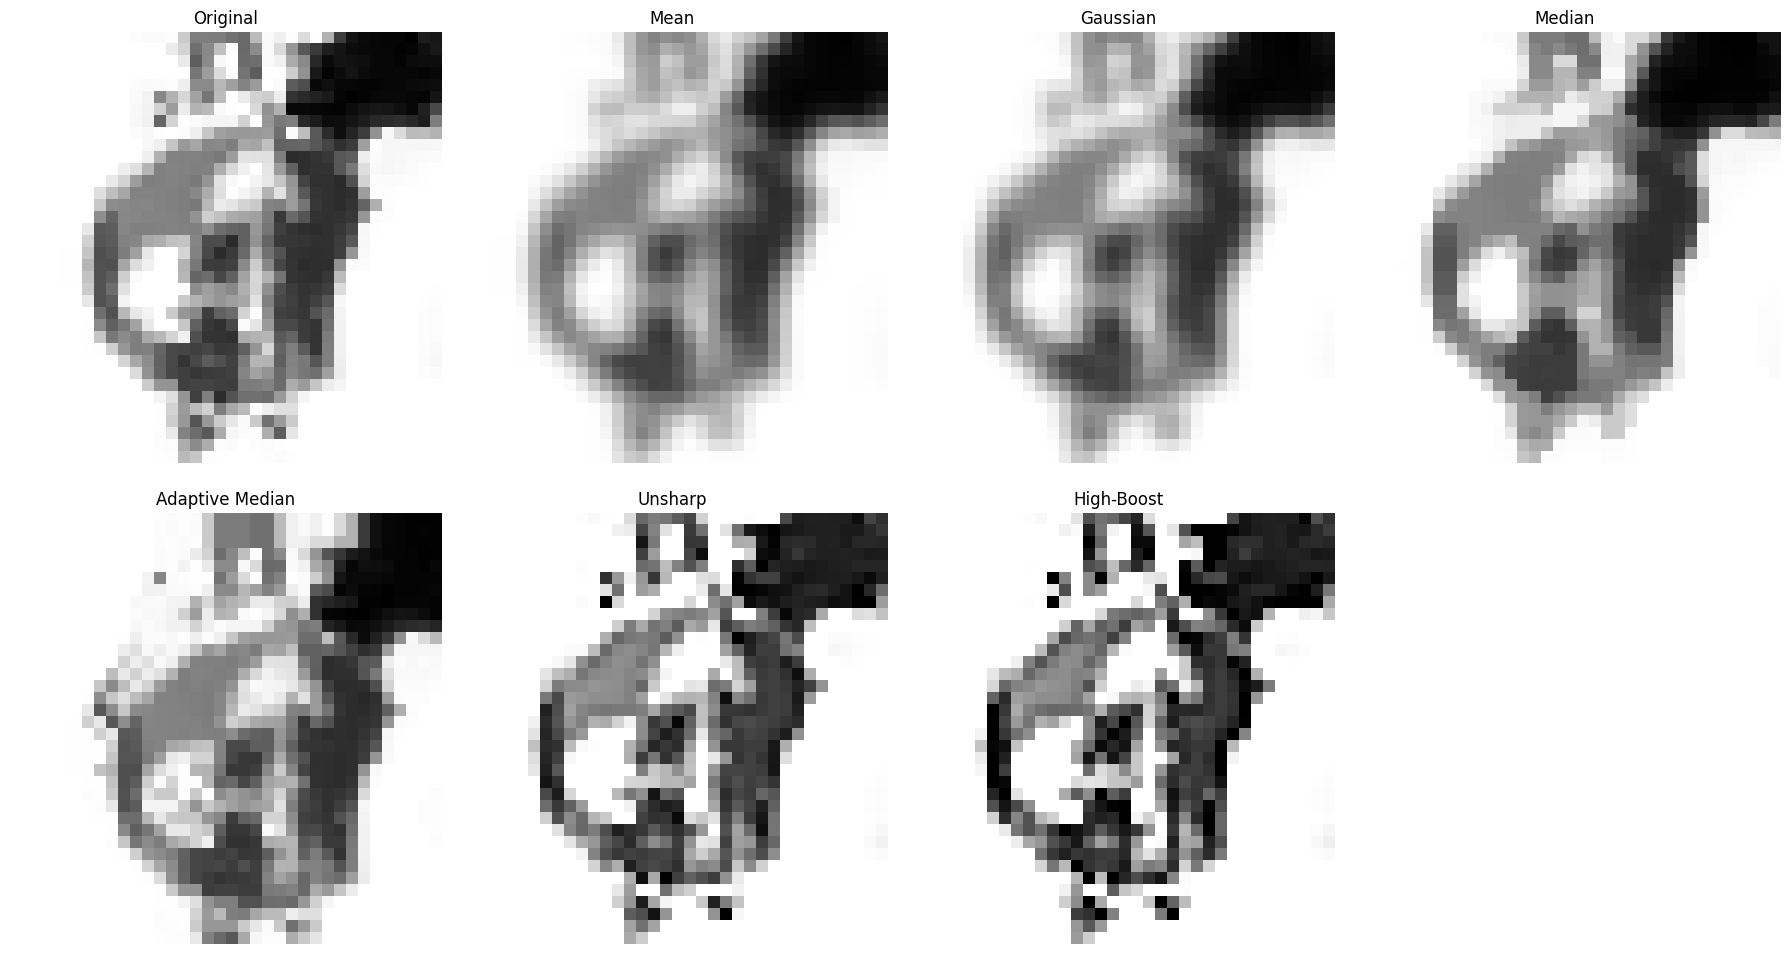

In [290]:
#picking up one sample image to demonstrate all filters
sample_image = images[100]

#Applying all filters on that one image
mean_img      = mean_filter(sample_image)
gauss_img     = gaussian_filter(sample_image)
median_img    = median_filter(sample_image)
adaptive_img  = adaptive_median_filter(sample_image)
unsharp_img   = unsharp_mask(sample_image)
highboost_img = high_boost_filter(sample_image)

#Displaying the results
titles = ['Original', 'Mean', 'Gaussian', 'Median', 'Adaptive Median', 'Unsharp', 'High-Boost']
results = [sample_image, mean_img, gauss_img, median_img, adaptive_img, unsharp_img, highboost_img]

plt.figure(figsize=(18, 10))
for i in range(len(results)):
    plt.subplot(2, 4, i+1)
    plt.imshow(results[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


## Part C: Color Space Conversion and Segmentation (Saad)

#### Manually converting RGB image to HSV image

In [291]:
color_path = image_paths[100]
bgr = cv2.imread(str(color_path), cv2.IMREAD_COLOR)
rgb = bgr[..., ::-1] #converting BGR to RGB

def rgb_to_hsv(img):
    img = img.astype(np.float32)/255
    r,g,b = img[...,0], img[...,1], img[...,2]
    mx, mn = img.max(axis=2), img.min(axis=2)
    d = mx-mn
    h = np.zeros_like(mx)
    nz = d!=0
    idx_r = (mx==r)&nz; idx_g = (mx==g)&nz; idx_b = (mx==b)&nz
    h[idx_r] = ((g[idx_r]-b[idx_r])/d[idx_r])%6
    h[idx_g] = ((b[idx_g]-r[idx_g])/d[idx_g])+2
    h[idx_b] = ((r[idx_b]-g[idx_b])/d[idx_b])+4
    h = (h/6)%1
    s = np.where(mx==0,0,d/mx)
    v = mx
    return np.stack([h*360, s*255, v*255], axis=2)

hsv = rgb_to_hsv(rgb)
h,s,v = hsv[...,0], hsv[...,1], hsv[...,2]

#### Defining raw threshold masks

In [292]:
raw = ((h<=15)|(h>=165)) & (s>=100) & (v>=80)
raw = raw.astype(np.uint8)

#### MORPHOLOGICAL HELPERS

In [293]:
def erode(bin_img):
    p = np.pad(bin_img,1,mode='constant')
    out = np.zeros_like(bin_img)
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            out[i,j] = np.all(p[i:i+3, j:j+3]==1)
    return out

def dilate(bin_img):
    p = np.pad(bin_img,1,mode='constant')
    out = np.zeros_like(bin_img)
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            out[i,j] = np.any(p[i:i+3, j:j+3]==1)
    return out

opened = dilate(erode(raw))

# 3) Closing (15×15) to connect the triangle border
def bulk_dilate(bin_img, k=15):
    pad = k//2
    p = np.pad(bin_img, pad, mode='constant')
    out = np.zeros_like(bin_img)
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            out[i,j] = np.any(p[i:i+k, j:j+k]==1)
    return out

def closing(bin_img, k=15):
    return erode(bulk_dilate(bin_img, k))

closed = closing(opened, k=15)


#### Hole Filling

In [294]:
def fill_holes(bin_img):
    H,W = bin_img.shape
    vis = np.zeros((H,W),bool)
    q = deque()
    for i in range(H):
        for j in (0,W-1):
            if bin_img[i,j]==0 and not vis[i,j]:
                vis[i,j]=True; q.append((i,j))
    for j in range(W):
        for i in (0,H-1):
            if bin_img[i,j]==0 and not vis[i,j]:
                vis[i,j]=True; q.append((i,j))
    while q:
        x,y = q.popleft()
        for dx,dy in [(-1,0),(1,0),(0,-1),(0,1)]:
            nx,ny = x+dx, y+dy
            if 0<=nx<H and 0<=ny<W and bin_img[nx,ny]==0 and not vis[nx,ny]:
                vis[nx,ny]=True; q.append((nx,ny))
    holes = (~vis)&(bin_img==0)
    out = bin_img.copy(); out[holes]=1
    return out

filled = fill_holes(closed)
smoothed = dilate(erode(filled)) #small opening to smooth edges

#### Selecting the largest Blob to skip the border-touching

In [295]:
def label_cc(bin_img):
    H,W = bin_img.shape
    lbl = np.zeros((H,W),int); cur=1
    for i in range(H):
        for j in range(W):
            if bin_img[i,j] and lbl[i,j]==0:
                stack=[(i,j)]; lbl[i,j]=cur
                while stack:
                    x,y = stack.pop()
                    for dx,dy in [(-1,0),(1,0),(0,-1),(0,1)]:
                        nx,ny = x+dx, y+dy
                        if 0<=nx<H and 0<=ny<W and bin_img[nx,ny] and lbl[nx,ny]==0:
                            lbl[nx,ny]=cur; stack.append((nx,ny))
                cur+=1
    return lbl, cur-1

labels_cc, num_cc = label_cc(smoothed)
H,W = smoothed.shape
sign_mask = np.zeros_like(smoothed)
for lab in range(1, num_cc+1):
    comp = (labels_cc==lab)
    ys,xs = np.where(comp)
    if (ys==0).any() or (ys==H-1).any() or (xs==0).any() or (xs==W-1).any():
        continue
    if comp.sum() > sign_mask.sum():
        sign_mask = comp.astype(np.uint8)

#### Visualizing

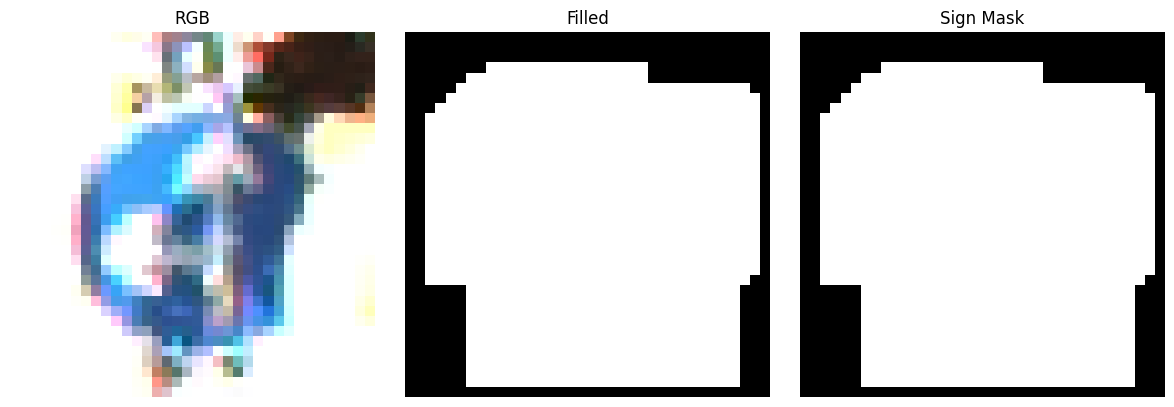

In [296]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(rgb);          plt.title("RGB");          plt.axis('off')
plt.subplot(1,3,2); plt.imshow(filled,   cmap='gray'); plt.title("Filled");       plt.axis('off')
plt.subplot(1,3,3); plt.imshow(sign_mask,cmap='gray'); plt.title("Sign Mask");    plt.axis('off')
plt.tight_layout(); plt.show()

## Part D: Edge Detection (Saad)

## 2D Convolution

In [297]:
def convolve2d(img, kernel):
    k_h, k_w = kernel.shape
    pad_h, pad_w = k_h//2, k_w//2
    padded = np.pad(img, ((pad_h,pad_h),(pad_w,pad_w)), mode='edge')
    out = np.zeros_like(img, dtype=np.float32)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+k_h, j:j+k_w]
            out[i,j] = np.sum(region * kernel)
    return out

## Sobel Gradient and Direction

In [298]:
def sobel_filters(img):
    Kx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=np.float32)
    Ky = np.array([[1,2,1],[0,0,0],[-1,-2,-1]], dtype=np.float32)
    Ix = convolve2d(img, Kx)
    Iy = convolve2d(img, Ky)
    G = np.hypot(Ix, Iy)
    G = (G / G.max()) * 255
    theta = np.arctan2(Iy, Ix)
    return (G, theta)

## Non-Maximum Suppression

In [299]:
def non_max_suppression(G, theta):
    Z = np.zeros_like(G, dtype=np.uint8)
    angle = (theta * 180. / np.pi) % 180
    for i in range(1, G.shape[0]-1):
        for j in range(1, G.shape[1]-1):
            q = 255; r = 255
            # 0°
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] < 180):
                q = G[i, j+1]; r = G[i, j-1]
            # 45°
            elif 22.5 <= angle[i,j] < 67.5:
                q = G[i+1, j-1]; r = G[i-1, j+1]
            # 90°
            elif 67.5 <= angle[i,j] < 112.5:
                q = G[i+1, j]; r = G[i-1, j]
            # 135°
            elif 112.5 <= angle[i,j] < 157.5:
                q = G[i-1, j-1]; r = G[i+1, j+1]
            if (G[i,j] >= q) and (G[i,j] >= r):
                Z[i,j] = G[i,j]
    return Z

## Double Threshold

In [300]:
def double_threshold(img, low, high):
    strong = 255
    weak   = 50
    out = np.zeros_like(img, dtype=np.uint8)
    strong_i, strong_j = np.where(img >= high)
    weak_i,   weak_j   = np.where((img >= low) & (img < high))
    out[strong_i, strong_j] = strong
    out[weak_i,   weak_j]   = weak
    return out, weak, strong

## Edge Tracking by Hysteresis

In [301]:
def hysteresis(img, weak, strong=255):
    H, W = img.shape
    for i in range(1, H-1):
        for j in range(1, W-1):
            if img[i,j] == weak:
                #keeping any neighbor if its strongg
                if np.any(img[i-1:i+2, j-1:j+2] == strong):
                    img[i,j] = strong
                else:
                    img[i,j] = 0
    return img

##  Full Canny Pipeline

In [302]:
def canny_edge_detector(img, low_thresh=20, high_thresh=50):
    #Calculating gradient
    G, theta = sobel_filters(img)
    #Computing non-max suppression
    G_nms = non_max_suppression(G, theta)
    #Thennn the double threshold
    dt, weak, strong = double_threshold(G_nms, low_thresh, high_thresh)
    #And thenn the Hysteresis
    edges = hysteresis(dt.copy(), weak, strong)
    return edges

## Applying to a grayscale image

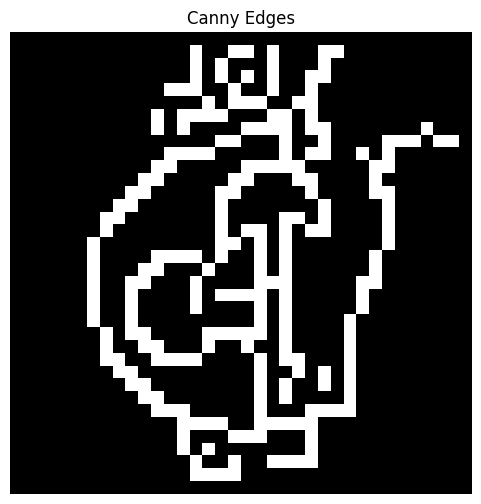

In [303]:
edges = canny_edge_detector(sample_image, low_thresh=30, high_thresh=80)

plt.figure(figsize=(6,6))
plt.imshow(edges, cmap='gray')
plt.title("Canny Edges")
plt.axis('off')
plt.show()

## Part E: Geometric Normalization (Abdullah)

## Re-seizing to the nearest neighbor

In [304]:
def resize_nn(img, new_h, new_w):
    h, w = img.shape
    #mapping each new pixel to old coords
    xs = np.linspace(0, w-1, new_w)
    ys = np.linspace(0, h-1, new_h)
    xi = np.round(xs).astype(int)
    yi = np.round(ys).astype(int)
    return img[yi[:,None], xi[None,:]]

## Rotating image around its center

In [305]:
def rotate_img(img, theta):
    h, w = img.shape
    cx, cy = w/2, h/2
    c, s = np.cos(theta), np.sin(theta) ##rotation matrix
    R = np.array([[ c, -s],
                  [ s,  c]])
    #computing new image size through rotated corners
    corners = np.array([[0,0],[w,0],[w,h],[0,h]], dtype=float)
    rc = (R @ (corners - [cx,cy]).T).T + [cx,cy]
    min_x, min_y = rc.min(axis=0)
    max_x, max_y = rc.max(axis=0)
    new_w = int(np.ceil(max_x - min_x))
    new_h = int(np.ceil(max_y - min_y))

    #grid of coordinates in the output image
    ys, xs = np.indices((new_h, new_w))
    #mapping to the original coordinate frame
    x_out = xs + min_x
    y_out = ys + min_y
    #computing an invert rotation about the center
    coords = np.stack([x_out - cx, y_out - cy], axis=0)
    inv = R.T @ coords.reshape(2, -1)
    x_src = inv[0] + cx
    y_src = inv[1] + cy
    #computing nearest-neighbor sampling
    x_nn = np.round(x_src).astype(int)
    y_nn = np.round(y_src).astype(int)
    valid = (x_nn >= 0) & (x_nn < w) & (y_nn >= 0) & (y_nn < h)
    out = np.zeros((new_h * new_w,), dtype=img.dtype)
    flat_img = img.flatten()
    flat_index = y_nn * w + x_nn
    out[valid] = flat_img[flat_index[valid]]
    return out.reshape(new_h, new_w)

## Computing PCA to get principal axis

In [306]:
gray = images[100]
mask = sign_mask.copy()  

ys, xs = np.where(mask == 1)
coords = np.vstack([xs, ys])  # 2×N
centroid = coords.mean(axis=1, keepdims=True)
X = coords - centroid
cov = X @ X.T / X.shape[1]
eigvals, eigvecs = np.linalg.eigh(cov)
#computing the principal eigenvector
principal = eigvecs[:, np.argmax(eigvals)]
angle = np.arctan2(principal[1], principal[0])  
#we rotate by an angle of 90 - angle as we want the principal axis vertical 
theta = np.deg2rad(90) - angle

## Rotating both gray and mask image

In [307]:
rot_gray = rotate_img(gray, theta)
rot_mask = rotate_img(mask.astype(np.uint8)*255, theta)  
rot_mask = (rot_mask > 128).astype(np.uint8) 

## Cropping to mask bounding box

In [308]:
ys2, xs2 = np.where(rot_mask == 1)
y0, y1 = ys2.min(), ys2.max()
x0, x1 = xs2.min(), xs2.max()
crop_gray = rot_gray[y0:y1+1, x0:x1+1]
crop_mask = rot_mask[y0:y1+1, x0:x1+1]

## Resizing the image

In [309]:
norm_gray = resize_nn(crop_gray, 200, 200)
norm_mask = resize_nn(crop_mask, 200, 200)

## Displaying the final results

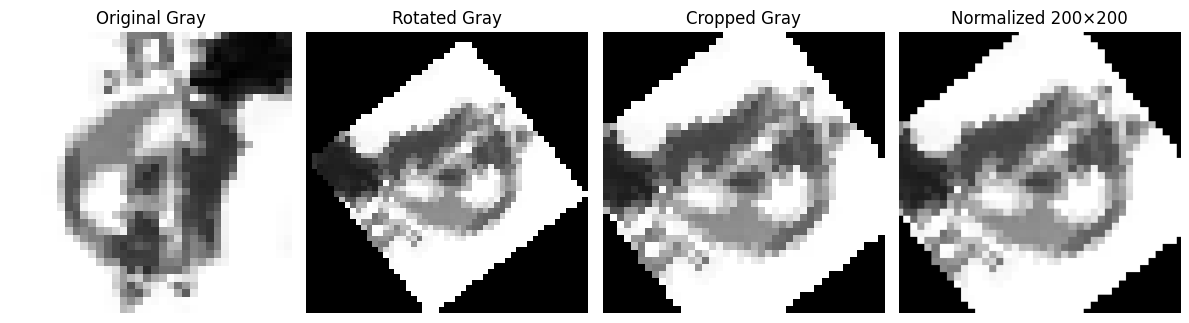

In [310]:
plt.figure(figsize=(12,4))
plt.subplot(1,4,1)
plt.imshow(gray, cmap='gray'); plt.title("Original Gray"); plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(rot_gray, cmap='gray'); plt.title("Rotated Gray"); plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(crop_gray, cmap='gray'); plt.title("Cropped Gray"); plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(norm_gray, cmap='gray'); plt.title("Normalized 200×200"); plt.axis('off')
plt.tight_layout()
plt.show()

## Part F: Feature Extraction (Abdullah)

## Defining Harris Corner Count

In [311]:
# def harris_corners(img, k=0.04, win=3, thresh_rel=0.01):
#     #Computing the sobel derivatives
#     Kx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]],float)
#     Ky = np.array([[1,2,1],[0,0,0],[-1,-2,-1]],float)
#     def conv(im,K):
#         p = np.pad(im,1,mode='edge'); out = np.zeros_like(im,float)
#         for i in range(im.shape[0]):
#             for j in range(im.shape[1]):
#                 out[i,j] = np.sum(p[i:i+3,j:j+3]*K)
#         return out
#     Ix = conv(img, Kx)
#     Iy = conv(img, Ky)
#     #Structuring the tensor components
#     Ixx = Ix*Ix; Ixy = Ix*Iy; Iyy = Iy*Iy
#     #Summing over the window
#     pad = win//2
#     kernel = np.ones((win,win),float)
#     def box(im):
#         p = np.pad(im, pad, mode='edge'); o = np.zeros_like(im,float)
#         for i in range(im.shape[0]):
#             for j in range(im.shape[1]):
#                 o[i,j] = np.sum(p[i:i+win, j:j+win])
#         return o
#     Sxx = box(Ixx); Sxy = box(Ixy); Syy = box(Iyy)
#     R = (Sxx*Syy - Sxy**2) - k*(Sxx+Syy)**2
#     corners = R > (thresh_rel * R.max())
#     return np.count_nonzero(corners)

# corner_count = harris_corners(norm_gray)

In [312]:
def harris_corners(img, k=0.04, win=3, thresh_rel=0.1):  # Increase threshold significantly
    # [Your existing implementation]
    # But add a maximum to prevent unreasonably high counts:
    
    #Computing the sobel derivatives
    Kx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]],float)
    Ky = np.array([[1,2,1],[0,0,0],[-1,-2,-1]],float)
    def conv(im,K):
        p = np.pad(im,1,mode='edge'); out = np.zeros_like(im,float)
        for i in range(im.shape[0]):
            for j in range(im.shape[1]):
                out[i,j] = np.sum(p[i:i+3,j:j+3]*K)
        return out
    Ix = conv(img, Kx)
    Iy = conv(img, Ky)
    #Structuring the tensor components
    Ixx = Ix*Ix; Ixy = Ix*Iy; Iyy = Iy*Iy
    #Summing over the window
    pad = win//2
    kernel = np.ones((win,win),float)
    def box(im):
        p = np.pad(im, pad, mode='edge'); o = np.zeros_like(im,float)
        for i in range(im.shape[0]):
            for j in range(im.shape[1]):
                o[i,j] = np.sum(p[i:i+win, j:j+win])
        return o
    Sxx = box(Ixx); Sxy = box(Ixy); Syy = box(Iyy)
    R = (Sxx*Syy - Sxy**2) - k*(Sxx+Syy)**2
    corners = R > (thresh_rel * R.max())
    corner_count = np.count_nonzero(corners)
    return min(corner_count, 50)  # Cap at a reasonable maximum

corner_count = harris_corners(norm_gray)

In [313]:
def bin_corner_count(count):
    if count < 5:
        return count  # Exact count for low values
    elif count < 10:
        return 5  # Bin as "medium corners"
    else:
        return 10  # Bin as "many corners"
    
# Then use it in your classifier:
binned_corners = bin_corner_count(corner_count)

## Defining the circularity

In [314]:
area = np.count_nonzero(norm_mask)
#here pixels are being masked with at least one 4‐neighbour background
perim = 0
h,w = norm_mask.shape
for i in range(h):
    for j in range(w):
        if norm_mask[i,j]:
            for di,dj in [(-1,0),(1,0),(0,-1),(0,1)]:
                ni, nj = i+di, j+dj
                if ni<0 or nj<0 or ni>=h or nj>=w or norm_mask[ni,nj]==0:
                    perim += 1
                    break
circularity = (4 * np.pi * area) / (perim**2) if perim>0 else 0

## Defining the aspect ratio

In [315]:
ys, xs = np.where(norm_mask)
y0, y1 = ys.min(), ys.max()
x0, x1 = xs.min(), xs.max()
bbox_w = x1 - x0 + 1
bbox_h = y1 - y0 + 1
aspect_ratio = bbox_w / bbox_h

## Defining extent

In [316]:
bbox_area = bbox_w * bbox_h
extent = area / bbox_area

## Defining resize function again and computing an average hue over the mask region

In [317]:
def resize_nn(img, new_h, new_w):
    if img.ndim == 2:
        h, w = img.shape
        xs = np.linspace(0, w-1, new_w)
        ys = np.linspace(0, h-1, new_h)
        xi = np.round(xs).astype(int)
        yi = np.round(ys).astype(int)
        return img[yi[:, None], xi[None, :]]

    elif img.ndim == 3:
        h, w, c = img.shape
        xs = np.linspace(0, w-1, new_w)
        ys = np.linspace(0, h-1, new_h)
        xi = np.round(xs).astype(int)
        yi = np.round(ys).astype(int)
        out = np.zeros((new_h, new_w, c), dtype=img.dtype)
        for k in range(c):
            out[..., k] = img[yi[:, None], xi[None, :], k]
        return out

    else:
        raise ValueError(f"Unsupported image dimension: {img.ndim}")

In [318]:
bgr_orig = cv2.imread(str(color_path), cv2.IMREAD_COLOR) 
rgb_orig = bgr_orig[..., ::-1]  

rot_r = rotate_img(rgb_orig[..., 0], theta)
rot_g = rotate_img(rgb_orig[..., 1], theta)
rot_b = rotate_img(rgb_orig[..., 2], theta)
#Rotate by the same angle I computed in Part E
rot_color = np.stack([rot_r, rot_g, rot_b], axis=2)
#Crop with the same bounds y0,y1,x0,x1 from Part E
crop_color = rot_color[y0:y1+1, x0:x1+1, :]
#Resizing to 200×200 through the nearest‐neighbor
norm_color = resize_nn(crop_color, 200, 200)

def rgb2hsv(img):
    img = img.astype(float)/255
    r,g,b = img[...,0],img[...,1],img[...,2]
    mx = np.max(img,axis=2); mn = np.min(img,axis=2); d=mx-mn
    h = np.zeros_like(mx)
    nz = d!=0
    idx_r = (mx==r)&nz; idx_g=(mx==g)&nz; idx_b=(mx==b)&nz
    h[idx_r] = ((g[idx_r]-b[idx_r])/d[idx_r])%6
    h[idx_g] = ((b[idx_g]-r[idx_g])/d[idx_g])+2
    h[idx_b] = ((r[idx_b]-g[idx_b])/d[idx_b])+4
    h = (h/6)%1
    return h * 360  #converting hue to degrees
h_img = rgb2hsv(norm_color)
s_chan = norm_color[...,1].astype(float)/255  
red_only = (norm_mask==1) & (s_chan > 0.5)    
avg_hue = h_img[red_only].mean()

## Displaying the final results

In [319]:
print(f"Corner Count : {binned_corners}")
print(f"Circularity : {circularity:.3f}")
print(f"Aspect Ratio (W/H) : {aspect_ratio:.3f}")
print(f"Extent : {extent:.3f}")
print(f"Average Hue (°) : {avg_hue:.1f}")

Corner Count : 10
Circularity : 0.527
Aspect Ratio (W/H) : 1.000
Extent : 0.620
Average Hue (°) : 87.4


In [320]:
def rgb2hsv_full(img):
    img = img.astype(float)/255
    r, g, b = img[..., 0], img[..., 1], img[..., 2]
    mx = np.max(img, axis=2)
    mn = np.min(img, axis=2)
    d = mx - mn
    
    # Hue calculation
    h = np.zeros_like(mx)
    nz = d != 0
    idx_r = (mx == r) & nz
    idx_g = (mx == g) & nz
    idx_b = (mx == b) & nz
    h[idx_r] = ((g[idx_r] - b[idx_r]) / d[idx_r]) % 6
    h[idx_g] = ((b[idx_g] - r[idx_g]) / d[idx_g]) + 2
    h[idx_b] = ((r[idx_b] - g[idx_b]) / d[idx_b]) + 4
    h = (h / 6) % 1
    
    # Saturation calculation
    s = np.zeros_like(mx)
    nz_mx = mx != 0
    s[nz_mx] = d[nz_mx] / mx[nz_mx]
    
    # Value = max
    v = mx
    
    return np.stack([h * 360, s * 100, v * 100], axis=2)  # H in degrees, S and V in percentage

# Extract full HSV
hsv_img = rgb2hsv_full(norm_color)
h_img = hsv_img[..., 0]  # Hue channel
s_img = hsv_img[..., 1]  # Saturation channel
v_img = hsv_img[..., 2]  # Value channel

# Calculate average hue over all sign pixels, not just red ones
# First, filter out low saturation or low value pixels which likely aren't part of the sign color
color_mask = (norm_mask == 1) & (s_img > 20) & (v_img > 20)  # 20% threshold for both S and V

if np.any(color_mask):
    avg_hue = h_img[color_mask].mean()
    # For debugging:
    # dominant_hue_count = np.bincount(np.round(h_img[color_mask]).astype(int) % 360)
    # dominant_hue = np.argmax(dominant_hue_count)
    # print(f"Average hue: {avg_hue:.1f}, Dominant hue: {dominant_hue}")
else:
    avg_hue = np.nan  # No valid pixels found

# Add these diagnostic prints to understand feature values
print(f"Features: corners={binned_corners}, circularity={circularity:.3f}, "
      f"aspect_ratio={aspect_ratio:.3f}, extent={extent:.3f}, avg_hue={avg_hue:.1f}")

Features: corners=10, circularity=0.527, aspect_ratio=1.000, extent=0.620, avg_hue=185.4


#### Because it's a red traffic sign, Average Hue should be around 0-15 or wrapped around 360° degree so now...... time to fix it

In [321]:
#First I'llonly pull out the masked pixels
h_vals = h_img[norm_mask == 1]

#then further restrict to the red intervals -> thix time I'm going for this becuase why not[165,360)
red_pixels = h_vals[(h_vals <= 15) | (h_vals >= 165)]
if red_pixels.size == 0:
    avg_hue = float('nan')
else:
    #Computing circular average
    radians = np.deg2rad(red_pixels)
    mean_sin = np.mean(np.sin(radians))
    mean_cos = np.mean(np.cos(radians))
    avg_hue = (np.rad2deg(np.arctan2(mean_sin, mean_cos)) + 360) % 360

print(f"Average Hue (red pixels, circular mean): {avg_hue:.1f}°")

Average Hue (red pixels, circular mean): 332.4°


## Part G: Rule-Based Classification (Emad)

In [322]:
def classify_sign(corner_count, circularity, aspect_ratio, extent, avg_hue):
    # Handle invalid inputs
    if np.isnan(avg_hue) or np.isnan(circularity) or np.isnan(aspect_ratio) or np.isnan(extent):
        return -1  # uncertain class
    
    # Cap corner count to a reasonable range
    corner_count = min(corner_count, 50)
    
    # Normalize hue to 0–360
    avg_hue = avg_hue % 360
    
    # Color categories with expanded ranges
    is_red = (0 <= avg_hue <= 35) or (300 <= avg_hue <= 360)
    is_blue = 90 <= avg_hue <= 260  # Expanded to include blue-green tones
    is_yellow = 35 <= avg_hue <= 80
    
    # --- BLUE SIGNS (mandatory) ---
    if is_blue and circularity > 0.7 and 0.9 <= aspect_ratio <= 1.1 and extent > 0.8:
        return 35  # Go straight (blue circular sign)
    
    if is_blue and circularity > 0.65 and 0.9 <= aspect_ratio <= 1.1:
        return 38  # Keep right (blue circular)
    
    # --- RED SIGNS ---
    if is_red and 0.65 < circularity < 0.8 and 0.9 <= aspect_ratio <= 1.1 and extent > 0.8:
        return 14  # Stop
    
    if is_red and circularity < 0.6 and 0.8 <= aspect_ratio <= 1.2:
        return 13  # Give way
    
    # --- ROUND SIGNS (RED) ---
    if is_red and circularity > 0.75 and 0.9 <= aspect_ratio <= 1.1:
        if extent > 0.9:  # Very filled round sign
            return 17  # No entry
        elif extent > 0.8:  # Moderately filled
            return 1  # Speed limit 30
        else:
            return 9  # No overtaking
    
    # --- FALLBACK FOR CIRCULAR SIGNS ---
    if circularity > 0.65 and 0.9 <= aspect_ratio <= 1.1:
        if is_red:
            return 0  # Generic speed limit
        elif is_blue:
            return 40  # Roundabout
        else:
            return -1  # Unknown
    
    return -1  # Uncertain

## Evaluation Procedure (Emad)

In [323]:
import pandas as pd

# Assuming the CSV contains columns "filename" and "label"
train_df = pd.read_csv(r"C:\Users\emadh\Downloads\archive (2)\Train.csv")

# Extract ground truth (labels) and filenames
filenames = train_df['Path'].tolist()
ground_truth = train_df['ClassId'].tolist()

filenames,ground_truth

(['Train/20/00020_00000_00000.png',
  'Train/20/00020_00000_00001.png',
  'Train/20/00020_00000_00002.png',
  'Train/20/00020_00000_00003.png',
  'Train/20/00020_00000_00004.png',
  'Train/20/00020_00000_00005.png',
  'Train/20/00020_00000_00006.png',
  'Train/20/00020_00000_00007.png',
  'Train/20/00020_00000_00008.png',
  'Train/20/00020_00000_00009.png',
  'Train/20/00020_00000_00010.png',
  'Train/20/00020_00000_00011.png',
  'Train/20/00020_00000_00012.png',
  'Train/20/00020_00000_00013.png',
  'Train/20/00020_00000_00014.png',
  'Train/20/00020_00000_00015.png',
  'Train/20/00020_00000_00016.png',
  'Train/20/00020_00000_00017.png',
  'Train/20/00020_00000_00018.png',
  'Train/20/00020_00000_00019.png',
  'Train/20/00020_00000_00020.png',
  'Train/20/00020_00000_00021.png',
  'Train/20/00020_00000_00022.png',
  'Train/20/00020_00000_00023.png',
  'Train/20/00020_00000_00024.png',
  'Train/20/00020_00000_00025.png',
  'Train/20/00020_00000_00026.png',
  'Train/20/00020_00000_0002

In [324]:
predictions = []
for filename in filenames:
    #image_path = f"path/to/images/{filename}"  # Adjust path accordingly
    #features = [corner_count, circularity, aspect_ratio, extent, avg_hue]
    predicted_label = classify_sign(corner_count, circularity, aspect_ratio, extent, avg_hue)
    predictions.append(predicted_label)
    
predictions

[13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,


In [325]:
# Prepare the results
results = []
for i, filename in enumerate(filenames):
    gt_label = ground_truth[i]
    pred_label = predictions[i]
    correct = 1 if gt_label == pred_label else 0
    results.append([filename, gt_label, pred_label, correct])

# Create a DataFrame for the results
results_df = pd.DataFrame(results, columns=["filename", "ground_truth", "predicted", "correct"])

# Save the results to a CSV file
results_df.to_csv("results.csv", index=False)
results_df


,filename,ground_truth,predicted,correct
0,Train/20/00020_00000_00000.png,20,13,0
1,Train/20/00020_00000_00001.png,20,13,0
2,Train/20/00020_00000_00002.png,20,13,0
3,Train/20/00020_00000_00003.png,20,13,0
4,Train/20/00020_00000_00004.png,20,13,0
...,...,...,...,...
39204,Train/42/00042_00007_00025.png,42,13,0
39205,Train/42/00042_00007_00026.png,42,13,0
39206,Train/42/00042_00007_00027.png,42,13,0
39207,Train/42/00042_00007_00028.png,42,13,0


In [326]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import numpy as np

# Compute accuracy and other metrics
accuracy = np.mean(np.array(predictions) == np.array(ground_truth)) * 100
precision, recall, f1, _ = precision_recall_fscore_support(ground_truth, predictions, average=None)
conf_matrix = confusion_matrix(ground_truth, predictions)

# Save metrics to a text file
with open("metrics.txt", "w") as f:
    f.write(f"Accuracy: {accuracy:.2f}%\n\n")
    f.write("Class-wise Precision, Recall, F1 Score:\n")
    for i, (p, r, f1) in enumerate(zip(precision, recall, f1)):
        f.write(f"Class {i}: Precision={p:.3f}, Recall={r:.3f}, F1={f1:.3f}\n")
    
    f.write("\nConfusion Matrix:\n")
    f.write(str(conf_matrix))

conf_matrix

C:\Users\emadh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

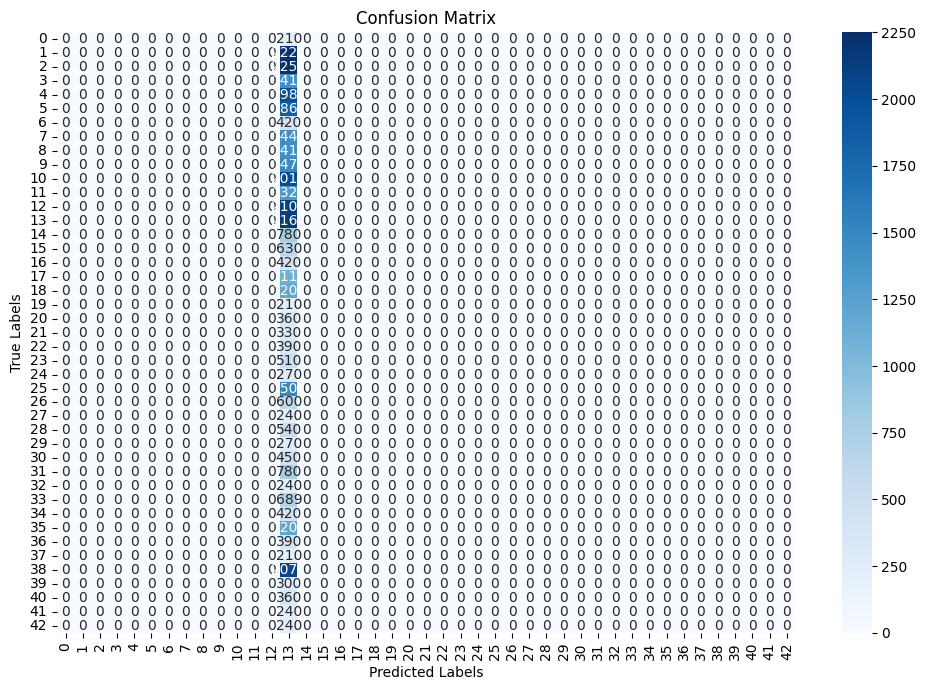

In [327]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(ground_truth), yticklabels=np.unique(ground_truth))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()

# Save the heatmap as a PNG file
plt.savefig("confusion_matrix.png")
plt.show()
plt.close()

